# 安装必要的环境

In [1]:
!pip install accelerate datasets -q

# 0、加载训练好的基座模型（qwen2.5-1.5B）

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os
import numpy as np
device = "cuda" # the device to load the model onto
model_name = "Qwen2___5-1___5B"
model_path = f'Qwen/{model_name}'

# 获取可用GPU设备的数量和内存信息
gpu_memory = {i: torch.cuda.get_device_properties(i).total_memory for i in range(torch.cuda.device_count())}
# 加载模型
try:
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype="auto",
        device_map="balanced",
        max_memory={i: f"{gpu_memory[i] // (1024 ** 3)}GB" for i in range(len(gpu_memory))}
    )
except Exception as e:
    print(f"Failed to load model from {model_path}: {e}")
    raise
# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [2]:
tokenizer.added_tokens_decoder

{151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151647: AddedToken("<|object_ref_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151648: AddedToken("<|box_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151649: AddedToken("<|box_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151650: AddedToken("<|quad_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151651: AddedToken("<|quad_end|>", rstrip=False, lstrip=

In [3]:
model.model.embed_tokens

Embedding(151936, 1536)

In [4]:
# 查看分词器中的special token
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|im_start|>',
  '<|im_end|>',
  '<|object_ref_start|>',
  '<|object_ref_end|>',
  '<|box_start|>',
  '<|box_end|>',
  '<|quad_start|>',
  '<|quad_end|>',
  '<|vision_start|>',
  '<|vision_end|>',
  '<|vision_pad|>',
  '<|image_pad|>',
  '<|video_pad|>']}

In [5]:
tokenizer.all_special_tokens

['<|endoftext|>',
 '<|im_start|>',
 '<|im_end|>',
 '<|object_ref_start|>',
 '<|object_ref_end|>',
 '<|box_start|>',
 '<|box_end|>',
 '<|quad_start|>',
 '<|quad_end|>',
 '<|vision_start|>',
 '<|vision_end|>',
 '<|vision_pad|>',
 '<|image_pad|>',
 '<|video_pad|>']

In [6]:
tokenizer.all_special_ids

[151643,
 151644,
 151645,
 151646,
 151647,
 151648,
 151649,
 151650,
 151651,
 151652,
 151653,
 151654,
 151655,
 151656]

In [7]:
model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "eos_token_id": 151643,
  "max_new_tokens": 2048
}

## 0.2 重设模型的generation_config文件

In [8]:
model.generation_config.do_sample = True
model.generation_config.eos_token_id = [151645, 151643]
model.generation_config.pad_token_id = 151643
model.generation_config.temperature = 0.7
model.generation_config.top_p = 0.8
model.generation_config.top_k = 20
model.generation_config.transformers_version = "4.37.0"
model.generation_config.repetition_penalty = 1.05

model.generation_config

GenerationConfig {
  "bos_token_id": 151643,
  "do_sample": true,
  "eos_token_id": [
    151645,
    151643
  ],
  "max_new_tokens": 2048,
  "pad_token_id": 151643,
  "repetition_penalty": 1.05,
  "temperature": 0.7,
  "top_k": 20,
  "top_p": 0.8
}

# 1、 新增`reasoning`special token + 同步调整模型的`embedding`层
- reasoning特殊标签格式：  **<|reasoning|>**
- 模型的分词器、嵌入层和lm_head均适配新增一个特殊token：<|reasoning|>

In [9]:
# 查看模型嵌入层
model.model.embed_tokens

Embedding(151936, 1536)

In [10]:
# 查看模型的vocab_size
tokenizer.vocab_size

151643

In [11]:
len(tokenizer)

151665

In [12]:
len(tokenizer) - tokenizer.vocab_size

22

In [13]:
import numpy as np
{k:v for k,v in zip([i for i in np.arange(tokenizer.vocab_size, len(tokenizer))], [tokenizer.decode(i) for i in np.arange(tokenizer.vocab_size, len(tokenizer))])}

{151643: '<|endoftext|>',
 151644: '<|im_start|>',
 151645: '<|im_end|>',
 151646: '<|object_ref_start|>',
 151647: '<|object_ref_end|>',
 151648: '<|box_start|>',
 151649: '<|box_end|>',
 151650: '<|quad_start|>',
 151651: '<|quad_end|>',
 151652: '<|vision_start|>',
 151653: '<|vision_end|>',
 151654: '<|vision_pad|>',
 151655: '<|image_pad|>',
 151656: '<|video_pad|>',
 151657: '<tool_call>',
 151658: '</tool_call>',
 151659: '<|fim_prefix|>',
 151660: '<|fim_middle|>',
 151661: '<|fim_suffix|>',
 151662: '<|fim_pad|>',
 151663: '<|repo_name|>',
 151664: '<|file_sep|>'}

可见，151643 - 151664 ，这22个元素是特殊token (有些甚至还是预留的适配多模态以及工具利用的特殊token标记)

In [14]:
# 因为我们导入的是基座模型（预训练模型），除了<|endoftext|> (<|endoftext|>嵌入在预训练过程中也会被训练) ，其他的特殊token应该都是随机初始化的，我们查看从第二行元素开始，嵌入是否都相同？
special_tensorweight = model.model.embed_tokens.weight[tokenizer.vocab_size+1: len(tokenizer)].detach()
print(special_tensorweight)
print(f'tensor size: {special_tensorweight.shape}')
# 选择第1个张量作为基准
reference_tensor = special_tensorweight[0]

# 定义一个容差值，用于比较浮点数是否相等
tolerance = 1e-4

all_same = all(torch.allclose(tensor, reference_tensor, atol=tolerance) for tensor in special_tensorweight)

if all_same:
  print("所有张量都相同（在容差范围内）")
else:
  print("张量不都相同")

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)
tensor size: torch.Size([21, 1536])
所有张量都相同（在容差范围内）


In [15]:
# 那么 151665 - 151935 是什么token呢， 我们解码一下
tokenizer.decode(torch.tensor(np.arange(len(tokenizer), model.model.embed_tokens.weight.detach().shape[0]).tolist()))

''

可以看到这些都是无用的token（空字符串），至于为什么需要pad这些token，找到的一篇答复：https://huggingface.co/Qwen/Qwen1.5-72B-Chat/discussions/1#662883f568adf59b07b176d2

In [16]:
model.model.embed_tokens.weight.detach()[len(tokenizer):, :]

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)

可以看到，这些【151665 - 151935】的无用token也和上面**【151644 - 151664 】**的特殊token的嵌入相同

In [17]:
model.lm_head.weight[tokenizer.vocab_size+1:].detach()
# 即 【151644 - 151935】的token嵌入都相同

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)

In [18]:
# 再查看最后的`lm_head`层中151644之后的张量是否都相同
print(model.lm_head.weight[tokenizer.vocab_size+1:].detach())
special_token_lmhead_weight = model.lm_head.weight[tokenizer.vocab_size+1:].detach()  #除了<|endoftext|>，这个特殊token在预训练阶段也会被训练
# 选择一个张量作为基准
reference_tensor = special_token_lmhead_weight[0]

# 定义一个容差值，用于比较浮点数是否相等
tolerance = 1e-4

all_same = all(torch.allclose(tensor, reference_tensor, atol=tolerance) for tensor in special_token_lmhead_weight)

if all_same:
  print("所有张量都相同（在容差范围内）")
else:
  print("张量不都相同")

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16)
所有张量都相同（在容差范围内）


## 1.1、增加`<|reasoning|>`这个special token

In [19]:
print(f"before add new special token, the Vocabulary Size is: {len(tokenizer)}")
new_special_token = "<|reasoning|>"
tokenizer.add_special_tokens({"additional_special_tokens": [new_special_token]})
print(f"after add new special token, the Vocabulary Size is: {len(tokenizer)}")

before add new special token, the Vocabulary Size is: 151665
after add new special token, the Vocabulary Size is: 151666


In [20]:
# check the id of th new token
new_token_id = tokenizer.convert_tokens_to_ids(new_special_token)
print(f"the id of {new_special_token} is: {new_token_id}")

the id of <|reasoning|> is: 151665


## 1.2、新增 `<|reasoning|>` 该special token后，还需要同步调整模型的`embedding`层 **(可以不用执行)**

In [21]:
model.resize_token_embeddings(len(tokenizer))
model.to(device)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151666, 1536)
    (layers): ModuleList(
      (0-27): 28 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1536, out_features=1536, bias=True)
          (k_proj): Linear(in_features=1536, out_features=256, bias=True)
          (v_proj): Linear(in_features=1536, out_features=256, bias=True)
          (o_proj): Linear(in_features=1536, out_features=1536, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (up_proj): Linear(in_features=1536, out_features=8960, bias=False)
          (down_proj): Linear(in_features=8960, out_features=1536, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((1536,), eps=1e-06)
      )
    )
    (norm): Qw

可以看到 嵌入层`embed_tokens`和最后的输出层`lm_head`都新增加了一个维度，变为了`151666`，我们接下来分别查看下新增加的这个维度的嵌入和最后的分类头的映射weight

In [22]:
model.model.embed_tokens.weight[-22:]

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)

In [23]:
model.lm_head.weight[-22:]

tensor([[ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        ...,
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010],
        [ 0.0077,  0.0110, -0.0062,  ...,  0.0048,  0.0024,  0.0010]],
       device='cuda:0', dtype=torch.bfloat16, grad_fn=<SliceBackward0>)

- 看样子，qwen2系列的小模型的确是使用了参数共享tie_weights方法（embedding层和最后的lm_head层权值共享或者说权重绑定）以压缩参数量
- 没记错的话，qwen系列是只有小模型使用了参数共享方法，大些体量的模型并没有使用共享方法


In [24]:
# 测试编解码码效果
input_text = "this is a test with a new special token: <|reasoning|>. let's task it"
# 编码
input_ids = tokenizer.encode(input_text, return_tensors="pt")
# 再解码回去
tokenizer.decode(input_ids[0]) == input_text

True

In [22]:
tokenizer.decode(input_ids[0])

"this is a test with a new special token: <|reasoning|>. let's task it"

In [25]:
tokenizer.encode("<|reasoning|>", return_tensors="pt")

tensor([[151665]])

In [27]:
model.model.embed_tokens

Embedding(151666, 1536)

In [29]:
from peft import LoraConfig, TaskType, get_peft_model

config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    target_modules=["q_proj", "v_proj"], # 选择合适的target_modules：https://github.com/huggingface/peft/blob/main/src/peft/utils/constants.py#L78
    inference_mode=False, # 训练模式
    r=8, # LoRA 秩大小
    lora_alpha=32, # LoRA alaph，具体作用参见 LoRA 原理
    lora_dropout=0.1 # Dropout 比例
)

model = get_peft_model(model, config)

model.print_trainable_parameters()

trainable params: 1,089,536 || all params: 1,544,389,120 || trainable%: 0.0705


## 以上我们就完成了对模型的**分词器**、**嵌入层**和**lm_head**均适配新增一个特殊token：**<|reasoning|>**

# 2、定义模型训练过程中的超参

In [30]:
from dataclasses import dataclass
@dataclass
class modelConfig:
    max_length:int = 3000
    batch_size:int = 1
    gradient_accumulation_steps:int = 8
    log_iter:int = 400
    max_lr:float = 2e-5
    min_lr:float = 2e-6
    warmup_steps:int = 1000

# 3、导入训练数据并开启训练

In [31]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [32]:
import datasets
reasoning_data = datasets.load_dataset('KingNish/reasoning-base-20k')

In [33]:
# prompt: save the dataset into local file
reasoning_data.save_to_disk("./reasoning_data")

Saving the dataset (0/1 shards):   0%|          | 0/19944 [00:00<?, ? examples/s]

In [34]:
reasoning_data['train']

Dataset({
    features: ['user', 'reasoning', 'assistant', 'template', 'conversations'],
    num_rows: 19944
})

In [35]:
# 全部是单轮对话
max([len(i) for i in reasoning_data['train']['conversations']]) == 3

True

In [36]:
reasoning_data['train'] = reasoning_data['train'].map(lambda x: {
    **x,
    'user_template': "".join(["<|im_start|>user\n", x['user'], "<|im_end|>\n"]),
    'reasoning_template': "".join(["<|im_start|><|reasoning|>\n", x['reasoning'], "<|im_end|>\n"]),
    'assistant_template': "".join(["<|im_start|>assistant\n", x['assistant'], "<|im_end|>\n"]),
    'template_new': "".join([       "<|im_start|>system\nYou are a helpful assistant<|im_end|>\n", #添加系统提示词
                        "<|im_start|>user\n", x['user'], "<|im_end|>\n",
                        "<|im_start|><|reasoning|>\n", x['reasoning'], "<|im_end|>\n",
                        "<|im_start|>assistant\n", x['assistant'], "<|im_end|>\n"])
})

In [37]:
reasoning_data['train']

Dataset({
    features: ['user', 'reasoning', 'assistant', 'template', 'conversations', 'user_template', 'reasoning_template', 'assistant_template', 'template_new'],
    num_rows: 19944
})

In [38]:
# 探查数据
print(reasoning_data['train']['template_new'][0])

<|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Prove that the difference between two consecutive cubes cannot be divisible by 5, using the fact that the only possible remainders when a cube is divided by 5 are 0, 1, and -1.<|im_end|>
<|im_start|><|reasoning|>
Let's break down the problem step by step and reason through it.

**Understanding the Problem**

The problem asks us to prove that the difference between two consecutive cubes cannot be divisible by 5. To approach this problem, we need to understand what consecutive cubes are and how we can represent them mathematically.

Consecutive cubes are cubes of consecutive integers. For example, if we take the integer 2, its cube is 2^3 = 8. The next consecutive integer is 3, and its cube is 3^3 = 27. So, the difference between these two consecutive cubes is 27 - 8 = 19.

**Representing Consecutive Cubes Mathematically**

Let's represent the two consecutive cubes as n^3 and (n+1)^3, where n is an integer. The dif

In [39]:
# 确保编解码前后的文本对齐
assert tokenizer.decode(tokenizer.encode(reasoning_data['train']['template_new'][0], return_tensors="pt")[0]) == reasoning_data['train']['template_new'][0]

In [40]:
print(tokenizer.decode(tokenizer.encode(reasoning_data['train']['template_new'][0], return_tensors="pt", truncation=True, max_length=modelConfig.max_length)[0]))

<|im_start|>system
You are a helpful assistant<|im_end|>
<|im_start|>user
Prove that the difference between two consecutive cubes cannot be divisible by 5, using the fact that the only possible remainders when a cube is divided by 5 are 0, 1, and -1.<|im_end|>
<|im_start|><|reasoning|>
Let's break down the problem step by step and reason through it.

**Understanding the Problem**

The problem asks us to prove that the difference between two consecutive cubes cannot be divisible by 5. To approach this problem, we need to understand what consecutive cubes are and how we can represent them mathematically.

Consecutive cubes are cubes of consecutive integers. For example, if we take the integer 2, its cube is 2^3 = 8. The next consecutive integer is 3, and its cube is 3^3 = 27. So, the difference between these two consecutive cubes is 27 - 8 = 19.

**Representing Consecutive Cubes Mathematically**

Let's represent the two consecutive cubes as n^3 and (n+1)^3, where n is an integer. The dif

## 3.1、训练数据转化成tokenid：str -> tokenid

In [41]:
reasoning_data['train'] = reasoning_data['train'].map(lambda x: {
    **x,
    'truncated_token_id': tokenizer.encode(x['template_new'], truncation=True, max_length=modelConfig.max_length)
})

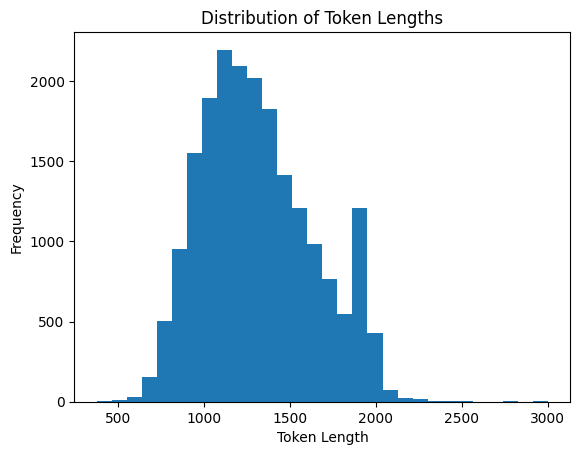

In [42]:
import matplotlib.pyplot as plt

token_lengths = [len(i) for i in reasoning_data['train']['truncated_token_id']]

plt.hist(token_lengths, bins=30)
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.title('Distribution of Token Lengths')
plt.show()

In [43]:
reasoning_data['train']

Dataset({
    features: ['user', 'reasoning', 'assistant', 'template', 'conversations', 'user_template', 'reasoning_template', 'assistant_template', 'template_new', 'truncated_token_id'],
    num_rows: 19944
})

In [44]:
assert tokenizer.decode(torch.tensor(reasoning_data['train'][0]['truncated_token_id'])) == reasoning_data['train'][0]['template_new']

## 3.2、使用设置的训练超参数

In [45]:
batch_size = modelConfig.batch_size
gradient_accumulation_steps = modelConfig.gradient_accumulation_steps
log_iter = modelConfig.log_iter
max_lr = modelConfig.max_lr
min_lr = modelConfig.min_lr
warmup_steps = modelConfig.warmup_steps
total_steps = len(reasoning_data['train'])//batch_size
optimizer = torch.optim.AdamW(filter(lambda p:p.requires_grad, model.parameters()), lr=max_lr)
trainable_parameters_num = sum(p.numel() for p in filter(lambda p:p.requires_grad, model.parameters()))  ##全参微调

## 3.3、配置logging日志记录模型训练过程

In [46]:
##配置logging
import time
with open(f"./{model_name}-SFT_log.txt", "a") as my_file:
  my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, batch_size:{batch_size}, trainable_parameters_num:{trainable_parameters_num}, warmup_steps:{warmup_steps}, max_lr:{max_lr}, min_lr:{min_lr}, gradient_accumulation_steps:{gradient_accumulation_steps}\n')
#定义一个日志记录函数
def log_call(iters, iters_average_loss):
  with open(f"./{model_name}-SFT_log.txt", "a") as my_file:
    my_file.write(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, iters_average_Loss:{iters_average_loss:.4f}\n')

## 3.4、学习率设置：余弦衰减学习率

In [47]:
def linear_warmup(current_step, warmup_steps, max_lr):
    if current_step < warmup_steps:
        return max_lr * current_step / warmup_steps
    else:
        return max_lr

def cosine_decay(current_step, warmup_steps, total_steps, max_lr, min_lr):
    if current_step < warmup_steps:
        return linear_warmup(current_step, warmup_steps, max_lr)
    else:
        progress = (current_step - warmup_steps) / (total_steps - warmup_steps)
        decay = 0.5 * (1 + np.cos(np.pi * progress))
        return (max_lr - min_lr) * decay + min_lr

## 3.5、掩码设置
- SFT和预训练的区别核心就是掩码掉“问题”部分的损失，而【只看“回答”部分的损失】，并仅基于回答部分的损失进行优化
- 实现方式：【构造损失掩码】，仅针对每轮对话（含多轮）的模型“输出”部分（也就是回答部分，**本处默认包含reasoning部分**）进行损失计算

In [48]:
# 设置问题部分的掩码函数，用于执行仅针对回答部分（此处默认包含reasoning部分）才计算损失
def return_answer_mask(input_ids):
  assistant_answer_mask = torch.zeros_like(input_ids) #0初始化
  for i in range(input_ids.shape[0]):
        ## user部分的结尾\n: \n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】，关于聊天模版可阅读这篇文章：https://huggingface.co/blog/chat-templates
        i_user_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[1::3]]   #第1个im_end开始
        ## assistant部分的结尾\n：\n是<|im_end|>的下一个元素，所以有+1 【这个地方需要根据不同模型的不同聊天模版自定义更改】
        i_assistant_end_list = [i+1 for i in torch.where(input_ids[i]==tokenizer.encode('<|im_end|>')[0])[0].tolist()[3::3]] #第3个im_end开始

        if len(i_user_end_list)==len(i_assistant_end_list):
            for user_end, assistant_end in zip(i_user_end_list, i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1 #+3的操作，【这个地方需要根据不同模型的不同聊天模版自定义更改】
        elif len(i_user_end_list)==len(i_assistant_end_list)+1==1:  ##单轮问答,且回答部分未结尾就被截断了
            assistant_answer_mask[i][i_user_end_list[0]+3:]=1  ##会把右补的padding token也标记为1，所以后面还需要再结合padding mask以过滤padding
        elif len(i_user_end_list)==len(i_assistant_end_list)+1:   ##兼顾多轮问答
            assistant_answer_mask[i][i_user_end_list[-1]+3:]=1
            for user_end, assistant_end in zip(i_user_end_list[:-1], i_assistant_end_list):
                assistant_answer_mask[i][user_end+3:assistant_end-1]=1
        else:
            continue  ##跳出当前循环，继续下一次循环
  return assistant_answer_mask

## 3.6、开启SFT微调训练

In [49]:
model.train()
train_loss_list = []
model.zero_grad() ##clear gradients at the start of training
ignore_iters_count = 0
for iters in range(len(reasoning_data['train'])//batch_size):
    ## 获取批次数据
    chosen_batch_inputids = reasoning_data['train'][iters*batch_size:(iters+1)*batch_size]['truncated_token_id']

    ## 对该批次数据进行padding,以并行计算，首先计算该批次的最大token长度
    chosen_max_dim = max([len(i) for i in chosen_batch_inputids])

    ### 训练数据padding填充
    chosen_batch_inputids_padding_list = []
    for i in range(batch_size):
        chosen_batch_inputids_padding_list.append(torch.nn.functional.pad(torch.tensor(chosen_batch_inputids[i]), (0, chosen_max_dim - len(chosen_batch_inputids[i])), mode='constant', value=model.generation_config.eos_token_id[-1]).tolist()) #右补
    chosen_batch_inputids_tensor = torch.tensor(chosen_batch_inputids_padding_list)

    ## 构建训练数据：x->y ,下一个单词预测
    chosen_x = chosen_batch_inputids_tensor[:, :-1].to(device)
    chosen_y = chosen_batch_inputids_tensor[:, 1:].to(device)

    ## 构建掩码判别矩阵（paddding mask & answer_mask, padding mask用于执行对padding的token不计算损失，answer_mask用于执行仅针对回答部分才计算损失），总之，就是确认哪些tokens的logit需要"忽视"掉
    ### 【padding mask】
    chosen_padding_mask = torch.where(chosen_y==model.generation_config.eos_token_id[-1], 0, 1)
    ### 【answer_mask】
    chosen_assistant_answer_mask = return_answer_mask(chosen_x)
    ### 【paddingmask & answermask】方便使用掩码判别矩阵对logit和y进行过滤->:我们只关注【回答】部分的损失，不关注问题部分的损失
    chosen_assistant_answer_mask = (chosen_assistant_answer_mask&chosen_padding_mask)

    if chosen_assistant_answer_mask.sum(dim=-1).min().item()==0:##如果该批次里有的问答数据在数据截取时，回答部分存在没有数据的情况（问题太长了，导致还未采集到回答部分的token就被硬截断了），那么该批次数据不再训练
      #print(f'不处理第{iters+1}批次数据')
      ignore_iters_count+=1
      continue  #跳出当前循环

    ## 执行训练数据的模型前向推理，计算logits
    chosen_logits = model(chosen_x).logits
    torch.cuda.empty_cache() #清除非必要的显存占用，但会导致速度变慢
    torch.cuda.ipc_collect()

    ## Compute Chosen_Answer_Loss，计算训练数据的回答部分的损失, batch_loss的shape_size:[batch_size]
    batch_loss = torch.mul((torch.gather(torch.log(torch.softmax(chosen_logits, dim=-1)), dim=-1, index=chosen_y.unsqueeze(2))*(-1)).squeeze(2), chosen_assistant_answer_mask).sum(dim=-1) / chosen_assistant_answer_mask.sum(dim=-1)

    ## Calculate the Final Loss, 只是新增了梯度积累的操作
    loss = torch.nanmean(batch_loss)/(gradient_accumulation_steps)

    loss.backward() ##反向传播计算梯度

    # Compute the learning rate for the current step
    lr = cosine_decay(iters, warmup_steps, total_steps, max_lr, min_lr)

    # Update the learning rate for the AdamW optimizer
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    if (iters+1)%gradient_accumulation_steps==0 or (iters+1)==(len(reasoning_data['train'])//batch_size):
        optimizer.step() #update weights after gradients accumulation
        ##at last, clear gradients
        optimizer.zero_grad() #clear gradients after updating, in this case equal to model.zero_grad()

    train_loss_list.append(loss.item()*gradient_accumulation_steps)

    if (iters+1)%log_iter==0 or (iters+1)==(len(reasoning_data['train'])//batch_size):
      print(f'time:{time.strftime("%Y-%m-%d, %H:%M:%S")}, iters:{iters+1}, last_{log_iter}_iters_average_train_Loss:{np.nanmean(train_loss_list[-log_iter:]):.4f}') ##避免空值影响
      log_call(iters, np.nanmean(train_loss_list[-log_iter:]))
    #过程中，保存模型
    if ((iters+1)*(modelConfig.batch_size))%2000==0:
        torch.save(model.state_dict(),f"./{model_name}_SFT.pth")

print("Totally Completed!")
print(f'共计忽略{ignore_iters_count}个批次数据')

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


time:2024-10-17, 18:28:04, iters:400, last_400_iters_average_train_Loss:0.5849
time:2024-10-17, 18:29:09, iters:800, last_400_iters_average_train_Loss:0.5885
time:2024-10-17, 18:30:16, iters:1200, last_400_iters_average_train_Loss:0.5404
time:2024-10-17, 18:31:21, iters:1600, last_400_iters_average_train_Loss:0.5212
time:2024-10-17, 18:32:24, iters:2000, last_400_iters_average_train_Loss:0.5062
time:2024-10-17, 18:33:31, iters:2400, last_400_iters_average_train_Loss:0.4963
time:2024-10-17, 18:34:35, iters:2800, last_400_iters_average_train_Loss:0.4843


KeyboardInterrupt: 

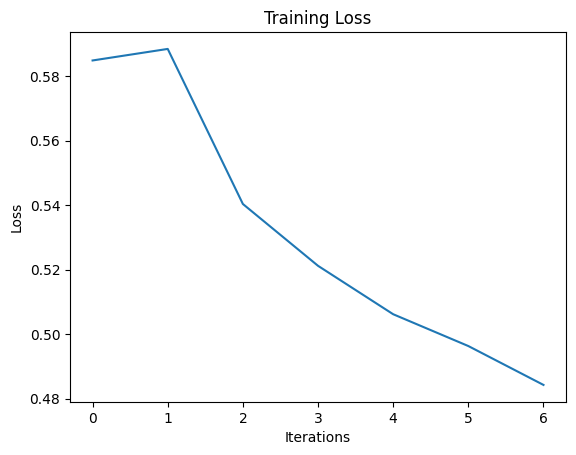

In [50]:
import matplotlib.pyplot as plt
interval = 400
# Assuming train_loss_list contains the loss values from your training
plt.plot([np.nanmean(train_loss_list[i*interval:(i+1)*interval]) for i in range(len(train_loss_list)//interval)])
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 3.7、保存模型

In [51]:
torch.save(model.state_dict(),f"./{model_name}_SFT.pth")

# 4、测试模型问答效果

In [52]:
from typing import List, Dict

def new_apply_chat_template(history:List[Dict[str, str]], add_reasoning_generation_prompt:bool=True, add_assistant_generation_prompt:bool=False):
  if add_reasoning_generation_prompt:
    return "".join([f"<|im_start|>{i['role']}\n{i['content']}<|im_end|>\n" for i in history]) + "<|im_start|><|reasoning|>\n"
  if add_assistant_generation_prompt:
    return "".join([f"<|im_start|>{i['role']}\n{i['content']}<|im_end|>\n" for i in history]) + "<|im_start|>assistant\n"

In [53]:
tokenizer.special_tokens_map

{'eos_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>',
 'additional_special_tokens': ['<|reasoning|>']}

In [ ]:
from IPython.display import Markdown, display

history = []
history.append({"role": "system", "content": "You are a helpful assistant"})
while True:
    question = input('User：' + '\n')
    print(question)
    print('\n')
    history.append({"role": "user", "content": question})

    input_text = new_apply_chat_template(
            history,
            add_reasoning_generation_prompt=True
        )
    model_inputs = tokenizer([input_text], return_tensors="pt").to(device)

    if model_inputs.input_ids.size()[1]>32000:
        break

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=3000
    )

    if len(generated_ids)>32000:
        break

    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

    reasoning_response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    history.append({"role": "<|reasoning|>", "content": reasoning_response})
    print('reasoning:\n')
    #print(response)
    display(Markdown(reasoning_response))
    print("------------")
    print('\n')

    input_text = new_apply_chat_template(
            history,
            add_assistant_generation_prompt=True
        )
    model_inputs = tokenizer([input_text], return_tensors="pt").to(device)

    if model_inputs.input_ids.size()[1]>32000:
        break

    generated_ids = model.generate(
        model_inputs.input_ids,
        max_new_tokens=3000
    )

    if len(generated_ids)>32000:
        break

    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(model_inputs.input_ids, generated_ids)]

    assistant_response = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
    history.append({"role": "assistant", "content": assistant_response})
    print('assistant:\n')
    display(Markdown(assistant_response))
    print("------------")

print("超过模型字数上线，已退出")

User：
 Please find all prime numbers within 0-10


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Please find all prime numbers within 0-10


reasoning:



To find all prime numbers within the range of 0 to 10, we can follow these steps:

**Understanding the Problem**

The problem asks us to identify and list all prime numbers that fall between 0 and 10. A prime number is a natural number greater than 1 that has no positive divisors other than 1 and itself.

**Breaking Down the Problem**

To solve this problem, we need to understand what makes a number prime. We know that a prime number cannot be divided evenly by any number other than 1 and itself. Therefore, we need to iterate through each number in the range and check if it is prime.

**Defining the Constraints**

The constraints for this problem are:
* The input range is from 0 to 10.
* We need to identify all prime numbers within this range.

**Identifying the Key Concepts**

The key concepts involved in solving this problem are:
* Prime numbers: Numbers that have no divisors other than 1 and themselves.
* Iteration: Repeatedly performing a task until a specific condition is met.
* Modulo operation: The remainder of a division operation.

**Developing the Solution**

To develop a solution, we can start by defining a function that checks whether a given number is prime. We can then iterate through each number in the range and call this function to determine if it is prime.

Here's a Python implementation of the solution:

```python
def is_prime(n):
    if n <= 1:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

for num in range(0, 11):
    if is_prime(num):
        print(num)
```

This code defines a function `is_prime` that takes a number `n` as input and returns `True` if `n` is prime, and `False` otherwise. It uses a loop to iterate through each number in the range and calls the `is_prime` function to determine if it is prime.

The outer loop iterates through each number in the range from 0 to 10, inclusive. For each number, the `is_prime` function is called to determine if it is prime. If it is, the number is printed.

**Self-Reflection**

This solution involves iterating through each number in the range and checking if it is prime using the `is_prime` function. The `is_prime` function checks if the number is less than or equal to 1, and if so, returns `False`. Otherwise, it iterates through each number up to the square root of the number and checks if it is divisible evenly by any number. If it is, the function returns `False`. If not, it returns `True`.

The use of the modulo operation (`%`) allows us to determine if a number is divisible evenly by another number. In this case, we check if the number is divisible evenly by any number from 2 to the square root of the number.

Overall, this solution is efficient and effective in identifying all prime numbers within the range of 0 to 10.<TKeyö>
<TKeyöassistant
Certainly! Here's a step-by-step explanation of how we can find all prime numbers within the range of 0 to 10:

**Step 1:** Define a function `is_prime(n)` that takes an integer `n` as input and returns `True` if `n` is prime, and `False` otherwise.

**Step 2:** Iterate through each number in the range from 0 to 10, inclusive.

**Step 3:** For each number, check if it is less than or equal to 1. If so, return `False` because prime numbers are greater than 1.

**Step 4:** For each number, iterate through each number from 2 to the square root of the number (inclusive).

**Step 5:** Check if the current number is divisible evenly by any number in the range. If it is, return `False` because it is not prime.

**Step 6:** If the current number is not divisible evenly by any number in the range, return `True` because it is prime.

**Step 7:** Print the prime numbers found in the range.

Let's break down each step further:

**Step 1:** The `is_prime(n)` function checks if a number `n` is prime. It does this by first checking if `n` is less than or equal to 1. If `n` is less than or equal to 1, it means that `n` is not prime because prime numbers are greater than 1. So, we return `False` in this case.

**Step 2:** We iterate through each number in the range from 0 to 10, inclusive. This means we will check every number in this range.

**Step 3:** For each number, we check if it is less than or equal to 1. If it is, we immediately return `False` because it is not prime.

**Step 4:** We iterate through each number from 2 to the square root of the current number (inclusive). This is where the magic happens. We check if the current number is divisible evenly by any number in this range. If it is, we return `False` because it is not prime.

**Step 5:** If the current number is not divisible evenly by any number in the range, we return `True` because it is prime.

**Step 6:** We print the prime numbers found in the range. This is important because it helps us verify that our algorithm is working correctly.

**Step 7:** Finally, we print the prime numbers found in the range. This is important because it helps us verify that our algorithm is working correctly.

By following these steps, we can find all prime numbers within the range of 0 to 10.<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10.<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are

------------


assistant:



greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for

------------


User：
 Please find all prime numbers within 0-10, don't use code.


Please find all prime numbers within 0-10, don't use code.


reasoning:



To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers
primes = []

# Iterate through each number in the range from 0 to 10, inclusive
for num in range(0, 11):
    # Skip to the next iteration if the number is less than or equal to 1
    if num <= 1:
        continue
    
    # Iterate through each number from 2 to the square root of the number (inclusive)
    for i in range(2, int(math.sqrt(num)) + 1):
        # Skip to the next iteration if the current number is divisible evenly by any number in the range
        if num % i == 0:
            continue
    
    # Add the current number to the list of prime numbers
    primes.append(num)

# Print the list of prime numbers
print(primes)
```

In this code, we first initialize an empty list `primes` to store the prime numbers. We then iterate through each number in the range from 0 to 10, inclusive. For each number, we check if it is less than or equal to 1. If it is, we skip to the next iteration because prime numbers are greater than 1. Next, we iterate through each number from 2 to the square root of the current number (inclusive). We check if the current number is divisible evenly by any number in the range. If it is, we skip to the next iteration because it is not prime. If the current number is not divisible evenly by any number in the range, we add it to the list of prime numbers. Finally, we print the list of prime numbers.

This approach ensures that we find all prime numbers within the range of 0 to 10<TKeyöassistant
<TKeyöassistant
To find all prime numbers within the range of 0 to 10, we can use the following approach:

1. Initialize an empty list to store the prime numbers.
2. Iterate through each number in the range from 0 to 10, inclusive.
3. For each number, check if it is less than or equal to 1. If so, skip to the next iteration because prime numbers are greater than 1.
4. For each number, iterate through each number from 2 to the square root of the number (inclusive).
5. Check if the current number is divisible evenly by any number in the range. If it is, skip to the next iteration because it is not prime.
6. If the current number is not divisible evenly by any number in the range, add it to the list of prime numbers.
7. After the loop finishes, print the list of prime numbers.

Here's the code:

```python
import math

# Initialize an empty list to store the prime numbers

------------


assistant:



```

------------
